## Ideally we should just show them how to use neural network for 1 classification task, and 1 regression task, then we will ask them to change size of the network (number of neurons and number of layers).


# Vanilla Neural Net

In these exercises, we will write a vanilla neural network to distinguish between kick and snare drum samples that we have in the data folder. First, we will write these for 

In [1]:
#import numpy
import numpy as np

#import librosa and display the library verion installed in yoru system
import librosa, librosa.display
print(librosa.__version__)

#import matplotlib 
import matplotlib.pyplot as plt

# Render plots interactively in the notebook (not a must)
#alternatively use matplotlib inline or matplotlib notebook or matplotlib nbagg
%matplotlib inline

#select a different color-scheme for the plots
import matplotlib.style as ms
ms.use('seaborn-muted')

#importing audio widget from IPython.display for audio playback
from IPython.display import Audio

#import scipy or scientific python
import scipy

#import os (helps retrieve the file names from the directory structure on your computer, and much more)
import os

import IPython.display as ipd

#iimport scikit-learn
import sklearn

#importing pandas for being able to load data from files such as comma separated values files
import pandas as pd

#import pathlib to easily write a function to work on all the files in a folder
from pathlib import Path

#importing scikit learn library for learning
import sklearn

0.6.2


#### Exercise 1
For this exercise, we will be training a multi layer perceptron to classify snare and kick drum samples from the Data/drum_samples files.

Multi-layer Perceptron (MLP) is a supervised learning algorithm that learns a function by training on a dataset, where is the number of dimensions for input and is the number of dimensions for output. Given a set of features and a target, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. Figure 1 shows a one hidden layer MLP with scalar output.
../_images/multilayerperceptron_network.png

Figure 1 : One hidden layer MLP.

The leftmost layer, known as the input layer, consists of a set of neurons
representing the input features. Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation , followed by a non-linear activation function

- like the hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

The module contains the public attributes coefs_ and intercepts_. coefs_ is a list of weight matrices, where weight matrix at index
represents the weights between layer and layer . intercepts_ is a list of bias vectors, where the vector at index represents the bias values added to layer

<img src="https://scikit-learn.org/stable/_images/multilayerperceptron_network.png">

The advantages of Multi-layer Perceptron are:

        Capability to learn non-linear models.
        Capability to learn models in real-time (on-line learning) using partial_fit.

The disadvantages of Multi-layer Perceptron (MLP) include:

        MLP with hidden layers have a non-convex loss function where there exists more than one local minimum. Therefore different random weight initializations can lead to different validation accuracy.
        MLP requires tuning a number of hyperparameters such as the number of hidden neurons, layers, and iterations.
        MLP is sensitive to feature scaling.



In [2]:
from sklearn.linear_model import Perceptron

## Creating the dataset
First, we need to have a dataset that we can train our model on.

In [3]:
#The next line of code includes an inline for loop 
#which will load all .mp3 samples starting with kick into kick_signals.
#The * star is also called wildcard, the librosa.load will be performed on all files which name starts
#with kick and ends with .wav (e.g. kick_03.wav, but also kick_adsugds.wav which we do not have in the folder).
#Mind that the sampling rate is the default one (do you remember the value?).
#The code below will actually create a LIST (squared brackets in Python) of Numpy arrays.
#Te have to take this approach because we are not sure that if files have the same number of samples (they do not)
#othrwise we could use a matrix (aka N dimensional Numpy array).
kick_signals = [ librosa.load(p, mono=True)[0] for p in Path().glob('Data/drum_samples/kick*.wav') ]


#Repeating the same for snare samples
snare_signals = [ librosa.load(p, mono=True)[0] for p in Path().glob('Data/drum_samples/snare*.wav') ]

#Repeating the same for 
cymbal_signals = [ librosa.load(p, mono=True)[0] for p in Path().glob('Data/drum_samples/cymbal*.wav')]

#Printing the size (lenght, using len() ) of the lists which includes kick and snares (separately).
#Does the number make sense versus what you have in the drum_samples folder?
print(len(kick_signals))
print(len(snare_signals))
print(len(cymbal_signals))

#Reduce the sizes of all signals to the max size of cymbal files>
kick_signals = kick_signals[0:18]
snare_signals = snare_signals[0:18]
print(len(kick_signals),len(snare_signals))

42
42
18
18 18


In [4]:
#Instead of writing the code to extract the features we define a function,
#which is more elegant, it's reusable (shorter code) and makes the following code more readable.
#All features (5 of them) are from librosa and are all scalar (we take the mean over multiple blocks).
#We have to do this (use average) because we did not check if all files have the same lenght (actually they are different).
#Different file lenght generates Numpy arrays of different lenght (not comparable)
#The function returns a list containing the mean of the features on "signal", which is the parameter we pass to the function
#Mind that these features may not be the best to perform the classification task (it's just an example!)
def extract_features(signal):

    return [
        np.mean(librosa.feature.zero_crossing_rate(signal)),
        np.mean(librosa.feature.spectral_centroid(signal)),
        np.mean(librosa.feature.spectral_contrast(signal)),
        np.mean(librosa.feature.rmse(signal)),
        np.mean(librosa.feature.spectral_flatness(signal)),
    ]


#Extracting our the 5 scalar features for all kick samples.
#Ee are using another inline for loop (this is very convenient when working with lists).
#Now we can store the data on an Numpy array because the size of the data is consistent,
#indeed we will have 5 numbers (features) per sample
#to be precise, we are still storing data into a list [], and then we use the function np.array
#to convert the list into an array (we need Numpy arrays for our ML algorithm, not lists)
kick_features = np.array([extract_features(x) for x in kick_signals])

#Repearing the same for the snare samples.
snare_features = np.array([extract_features(x) for x in snare_signals])

#repeating the same for cymbal samples
cymbal_features = np.array([extract_features(x) for x in cymbal_signals])

#Displaying the size of the Numpy arrays (this time we use the .shape attribute)
#Check if the printed numbers are the expected ones (what's on the rows and what's on the columns?)
print('Size of Numpy arrays for kick and snare features:')
print(kick_features.shape, snare_features.shape, cymbal_features.shape)

#Now we create an array of labels, we can use zeros for the kicks and ones for the snare (or any other number).
#This will help us to discriminate set of featires associated with kicks and snares
#We can opt for "text" labels but this is not convenient,
#It wont work well with neural networks, and we put "text" labels in Numpy arrays

#Create a row of zeroes as long as the number of kick samples
kicklabels = np.zeros(kick_features.shape[0])

#Create a row of ones as long as the number of snare samples
snarelabels = np.ones(snare_features.shape[0])

#Create a row of twos as long as the number of cymbal samples
cymballabels = np.full(len(cymbal_features),2)

#Now we concatenate (attach) the numeric labels into a single array,
#and we also concatenate the two set of features
labels = np.concatenate((kicklabels,snarelabels,cymballabels))
features = np.concatenate((kick_features,snare_features,cymbal_features))

#check the output and reconsile these with what we just did
print('Size of labels array',labels.shape)
print('Size of feature array',features.shape)

#Here we use the scale function of scikit-learn to scale the features,
#this is important when using hetherogeneous (different) scalar features.
#After this step all features will present zero mean and unit veriance (i.e. they are more comparable).
#It is way less recommended to do this with vectorial features.
#In this case we are overwiting the previous Numpy variable (or array) instead of creating a new one
#(it is fine if you do not need the old data anymore, and it reduces the number of variables you use in a program)
features = sklearn.preprocessing.scale(features)


#Moving the data into a Pandas structure and we assign name to each column (features are on column)
dataset = pd.DataFrame(features)
dataset.columns = ['ZC','SpecCen','SpecCon','RMS','SpecFlat']

#Sticking an extra colum as labels
dataset['Label'] = labels

#this will display the Pandas data structure
dataset

classes = ['kick','snare','cymbal']

Size of Numpy arrays for kick and snare features:
(18, 5) (18, 5) (18, 5)
Size of labels array (54,)
Size of feature array (54, 5)


# Preparing the data for the network

## First we train on only ONE feature in our dataset

In [5]:
# Assign data from first five columns of features to X variable
X = dataset.iloc[:, 0:1]

# Assign data from first fifth columns to y variable
y = dataset.iloc[:,5]


In [6]:
#Import the test train splitting from the model selection component from sklearn
from sklearn.model_selection import train_test_split

#use the train_test_split function to import the results to the following variables as the names suggest:
#X_train and y_train will contain training data and labels, while
#X_test and y_test will contain testing data and labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [7]:
#Import the classifier for the network
from sklearn.neural_network import MLPClassifier

#Call the classifier and specify the size of layers
mlp = MLPClassifier(hidden_layer_sizes=(2, 2), max_iter=500)

#Fit the mlp model to the training set
mlp.fit(X_train, y_train.values.ravel())

#Store the predictions of the network in a variable called predictions
predictions = mlp.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [8]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

#Store the confusion matrix in the variable confMat
confMat = confusion_matrix(y_test,predictions)

[[4 0 0]
 [3 0 2]
 [0 0 2]]
             precision    recall  f1-score   support

        0.0       0.57      1.00      0.73         4
        1.0       0.00      0.00      0.00         5
        2.0       0.50      1.00      0.67         2

avg / total       0.30      0.55      0.39        11



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


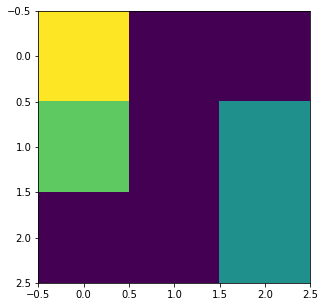

In [9]:
#Visualize the confusion matrix. Each block represents misclassified and correctly classified samples
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(confMat)

### As we see, the average precision is 80%, average recall and f1 score are both around barely 50%. We try again with 4 features

[[6 0 0]
 [0 2 3]
 [0 0 0]]
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00         6
        1.0       1.00      0.40      0.57         5
        2.0       0.00      0.00      0.00         0

avg / total       1.00      0.73      0.81        11



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


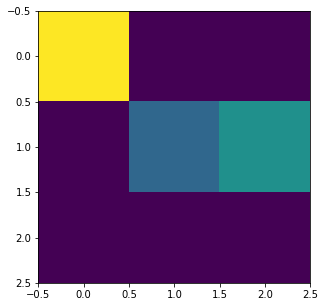

In [212]:
# Assign data from first five columns of features to X variable
X = dataset.iloc[:, 0:4]
#NOTE> THIS IS WHERE WE ASSIGN FEATURES to the X variable


# Assign data from first fifth columns to y variable
y = dataset.iloc[:,5]


#Import the test train splitting from the model selection component from sklearn
from sklearn.model_selection import train_test_split

#use the train_test_split function to import the results to the following variables as the names suggest:
#X_train and y_train will contain training data and labels, while
#X_test and y_test will contain testing data and labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)


#Import the classifier for the network
from sklearn.neural_network import MLPClassifier

#Call the classifier and specify the size of layers
mlp = MLPClassifier(hidden_layer_sizes=(2,2), max_iter=500)

#Fit the mlp model to the training set
mlp.fit(X_train, y_train.values.ravel())

#Store the predictions of the network in a variable called predictions
predictions = mlp.predict(X_test)

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
#Store the confusion matrix in the variable confMat
confMat = confusion_matrix(y_test,predictions)

#Visualize the confusion matrix. Each block represents misclassified and correctly classified samples
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(confMat)

### We see that the network somehow got worse even with the use of 4 features

## In the following code, we increase the network size even more, and also use many more iterations.

[[6 0 0]
 [0 2 0]
 [0 0 3]]
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00         6
        1.0       1.00      1.00      1.00         2
        2.0       1.00      1.00      1.00         3

avg / total       1.00      1.00      1.00        11



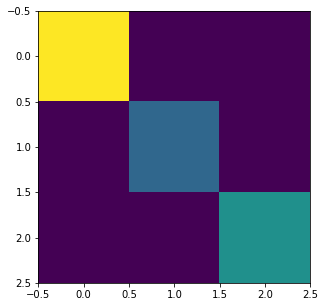

In [213]:
# Assign data from first five columns of features to X variable
X = dataset.iloc[:, 0:5]
#NOTE> THIS IS WHERE WE ASSIGN FEATURES to the X variable


# Assign data from first fifth columns to y variable
y = dataset.iloc[:,5]


#Import the test train splitting from the model selection component from sklearn
from sklearn.model_selection import train_test_split

#use the train_test_split function to import the results to the following variables as the names suggest:
#X_train and y_train will contain training data and labels, while
#X_test and y_test will contain testing data and labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)


#Import the classifier for the network
from sklearn.neural_network import MLPClassifier

#Call the classifier and specify the size of layers
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)

#Fit the mlp model to the training set
mlp.fit(X_train, y_train.values.ravel())

#Store the predictions of the network in a variable called predictions
predictions = mlp.predict(X_test)

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
#Store the confusion matrix in the variable confMat
confMat = confusion_matrix(y_test,predictions)

#Visualize the confusion matrix. Each block represents misclassified and correctly classified samples
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(confMat)

# Exercise 1:
### Experiment with learning rate
<br> Figure out how changing the learning rate in the parameters of the MLPCLassifier will change how the network performs.

### Stop condition
<br> Currently, the network stops when it has completed a maximum number of iterations. What other learning strategies could be used?

In [214]:
# Write your code here

# Exercise 2

### Implement the same network with a four classes with a new set of sound files.

In [215]:
#Write your code here

# Generate Sine Wave for Predictive Network

100000


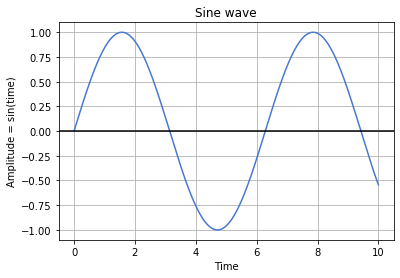

In [216]:
time = np.arange(0, 10, 0.0001);

# Amplitude of the sine wave is sine of a variable like time
amplitude = np.sin(time)

print(len(amplitude))

# Plot a sine wave using time and amplitude obtained for the sine wave
plt.plot(time, amplitude)
# Give a title for the sine wave plot
plt.title('Sine wave')
# Give x axis label for the sine wave plot
plt.xlabel('Time')
# Give y axis label for the sine wave plot
plt.ylabel('Amplitude = sin(time)')
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.show()
# Display the sine wave
plt.show()

In [217]:
starts = [np.random.randint(1,99800) for _ in range(1000)]
sines = []
for i in range(len(starts)):
    amparray = amplitude[starts[i]:starts[i]+100]
    sines.append(amparray)
np.array(sines).shape

(1000, 100)

In [218]:
df = pd.DataFrame(np.array(sines))
df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.032609,0.032709,0.032809,0.032909,0.033009,0.033109,0.033209,0.033309,0.033408,0.033508,...,0.041603,0.041703,0.041803,0.041902,0.042002,0.042102,0.042202,0.042302,0.042402,0.042502
1,-0.813930,-0.813872,-0.813814,-0.813756,-0.813698,-0.813640,-0.813581,-0.813523,-0.813465,-0.813407,...,-0.808669,-0.808610,-0.808551,-0.808492,-0.808433,-0.808374,-0.808315,-0.808257,-0.808198,-0.808139
2,0.082683,0.082584,0.082484,0.082384,0.082285,0.082185,0.082085,0.081986,0.081886,0.081787,...,0.073711,0.073611,0.073512,0.073412,0.073312,0.073212,0.073113,0.073013,0.072913,0.072813
3,-0.932512,-0.932548,-0.932584,-0.932620,-0.932656,-0.932692,-0.932729,-0.932765,-0.932801,-0.932837,...,-0.935724,-0.935760,-0.935795,-0.935830,-0.935865,-0.935901,-0.935936,-0.935971,-0.936006,-0.936042
4,0.996140,0.996148,0.996157,0.996166,0.996175,0.996183,0.996192,0.996201,0.996210,0.996218,...,0.996889,0.996897,0.996905,0.996913,0.996921,0.996929,0.996936,0.996944,0.996952,0.996960
5,0.031110,0.031210,0.031310,0.031410,0.031509,0.031609,0.031709,0.031809,0.031909,0.032009,...,0.040104,0.040204,0.040304,0.040404,0.040504,0.040604,0.040703,0.040803,0.040903,0.041003
6,0.176056,0.175957,0.175859,0.175760,0.175662,0.175563,0.175465,0.175366,0.175268,0.175170,...,0.167189,0.167091,0.166992,0.166893,0.166795,0.166696,0.166598,0.166499,0.166400,0.166302
7,0.533472,0.533556,0.533641,0.533726,0.533810,0.533895,0.533979,0.534064,0.534148,0.534233,...,0.541062,0.541147,0.541231,0.541315,0.541399,0.541483,0.541567,0.541651,0.541735,0.541819
8,0.690659,0.690731,0.690804,0.690876,0.690948,0.691021,0.691093,0.691165,0.691237,0.691310,...,0.697140,0.697211,0.697283,0.697355,0.697426,0.697498,0.697570,0.697641,0.697713,0.697785
9,0.733796,0.733728,0.733660,0.733592,0.733524,0.733456,0.733388,0.733320,0.733252,0.733184,...,0.727652,0.727583,0.727515,0.727446,0.727378,0.727309,0.727240,0.727172,0.727103,0.727034


In [223]:
X2_samples = df.iloc[:,0:99]
Y2_samples = df.iloc[:,99]

In [224]:
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X2_samples_scale = min_max_scaler.fit_transform(X2_samples)

In [225]:
from sklearn.model_selection import train_test_split
X2_train, X2_val_and_test, Y2_train, Y2_val_and_test = train_test_split(X2_samples_scale, Y2_samples, test_size=0.3)

In [226]:
X2_val, X2_test, Y2_val, Y2_test = train_test_split(X2_val_and_test, Y2_val_and_test, test_size=0.5)

In [228]:
print(X2_train.shape, X2_val.shape, X2_test.shape, Y2_train.shape, Y2_val.shape, Y2_test.shape)

(700, 99) (150, 99) (150, 99) (700,) (150,) (150,)


In [233]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential([
    Dense(32, activation='relu', input_shape=(99,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])

model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

hist = model.fit(X2_train, Y2_train,
          batch_size=32, epochs=100,
          validation_data=(X2_val, Y2_val))


Train on 700 samples, validate on 150 samples
Epoch 1/100
700/700 [==============================] - 0s 497us/step - loss: 0.6596 - acc: 0.0000e+00 - val_loss: 0.6358 - val_acc: 0.0000e+00
Epoch 2/100
700/700 [==============================] - 0s 77us/step - loss: 0.6044 - acc: 0.0000e+00 - val_loss: 0.5889 - val_acc: 0.0000e+00
Epoch 3/100
700/700 [==============================] - 0s 69us/step - loss: 0.5523 - acc: 0.0000e+00 - val_loss: 0.5429 - val_acc: 0.0000e+00
Epoch 4/100
700/700 [==============================] - 0s 57us/step - loss: 0.5001 - acc: 0.0000e+00 - val_loss: 0.4975 - val_acc: 0.0000e+00
Epoch 5/100
700/700 [==============================] - 0s 68us/step - loss: 0.4491 - acc: 0.0000e+00 - val_loss: 0.4520 - val_acc: 0.0000e+00
Epoch 6/100
700/700 [==============================] - 0s 49us/step - loss: 0.3974 - acc: 0.0000e+00 - val_loss: 0.4069 - val_acc: 0.0000e+00
Epoch 7/100
700/700 [==============================] - 0s 54us/step - loss: 0.3453 - acc: 0.0000e+00

In [235]:
model.evaluate(X2_test, Y2_test)[1]

150/150 [==============================] - 0s 117us/step


0.0

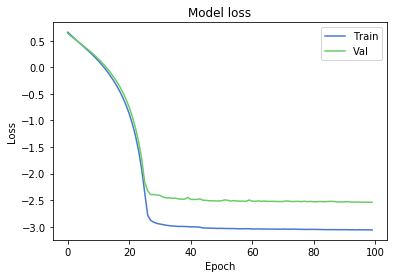

In [236]:
import matplotlib.pyplot as plt


plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

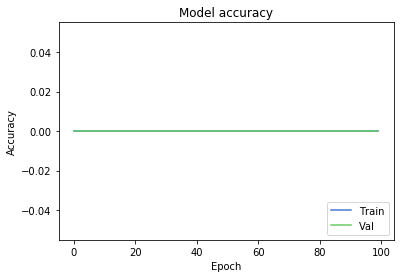

In [237]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [239]:
model_2 = Sequential([
    Dense(1000, activation='relu', input_shape=(99,)),
    Dense(1000, activation='relu'),
    Dense(1000, activation='relu'),
    Dense(1000, activation='relu'),
    Dense(1, activation='sigmoid'),
])

model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

hist_2 = model_2.fit(X2_train, Y2_train,
          batch_size=32, epochs=100,
          validation_data=(X2_val, Y2_val))

Train on 700 samples, validate on 150 samples
Epoch 1/100
700/700 [==============================] - 1s 2ms/step - loss: 0.6292 - acc: 0.0000e+00 - val_loss: 0.5568 - val_acc: 0.0000e+00
Epoch 2/100
700/700 [==============================] - 1s 1ms/step - loss: -1.2208 - acc: 0.0000e+00 - val_loss: -1.4875 - val_acc: 0.0000e+00
Epoch 3/100
700/700 [==============================] - 1s 1ms/step - loss: -1.7852 - acc: 0.0000e+00 - val_loss: -1.2273 - val_acc: 0.0000e+00
Epoch 4/100
700/700 [==============================] - 1s 1ms/step - loss: -2.3947 - acc: 0.0000e+00 - val_loss: -2.5781 - val_acc: 0.0000e+00
Epoch 5/100
700/700 [==============================] - 1s 1ms/step - loss: -3.0935 - acc: 0.0000e+00 - val_loss: -2.5981 - val_acc: 0.0000e+00
Epoch 6/100
700/700 [==============================] - 1s 1ms/step - loss: -3.0933 - acc: 0.0000e+00 - val_loss: -2.5870 - val_acc: 0.0000e+00
Epoch 7/100
700/700 [==============================] - 1s 1ms/step - loss: -3.1012 - acc: 0.0000e+

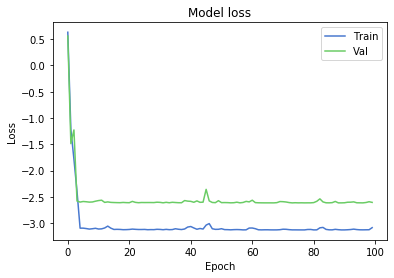

In [240]:
plt.plot(hist_2.history['loss'])
plt.plot(hist_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')

plt.show()

In [243]:
from keras.layers import Dropout
from keras import regularizers

model_3 = Sequential([
    Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(99,)),
    Dropout(0.3),
    Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)),
])

model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

hist_3 = model_3.fit(X2_train, Y2_train,
          batch_size=32, epochs=100,
          validation_data=(X2_val, Y2_val))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 700 samples, validate on 150 samples
Epoch 1/100
700/700 [==============================] - 2s 3ms/step - loss: 20.4922 - acc: 0.0000e+00 - val_loss: 10.0708 - val_acc: 0.0000e+00
Epoch 2/100
700/700 [==============================] - 1s 2ms/step - loss: 4.7905 - acc: 0.0000e+00 - val_loss: 1.3798 - val_acc: 0.0000e+00
Epoch 3/100
700/700 [==============================] - 1s 2ms/step - loss: -0.5789 - acc: 0.0000e+00 - val_loss: -0.9993 - val_acc: 0.0000e+00
Epoch 4/100
700/700 [==============================] - 1s 1ms/step - loss: -1.7753 - acc: 0.0000e+00 - val_loss: -1.5399 - val_acc: 0.0000e+00
Epoch 5/100
700/700 [==============================] - 1s 1ms/step - loss: -2.1475 - acc: 0.0000e+00 - val_loss: -1.7171 - val_acc: 0.0000e+00
Epoch 6/100
700/700 [==============================] - 1s 1ms/step - loss: -2.3147 - acc: 0.0000e+00 - val_loss: -1.7778 - val

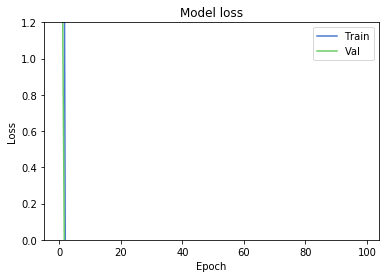

In [244]:
plt.plot(hist_3.history['loss'])
plt.plot(hist_3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylim(top=1.2, bottom=0)
plt.show()

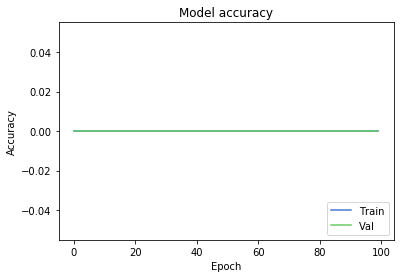

In [245]:
plt.plot(hist_3.history['acc'])
plt.plot(hist_3.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()